# Note:

Be sure running **German(Overall).R** and **ErrorTerm Generation.R** before running this script

Creating data **2 month** before and after the tretment

In [1]:
ger21 <- ger[ger$date >= "2010-10-03",]
ger21 <- ger21[ger21$date <= "2011-01-30",]

Loading required package: leaps
Loading required package: locfit
locfit 1.5-9.1 	 2013-03-22
Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-17. For overview type 'help("mgcv-package")'.
Loading required package: tseries

Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts
Loading required package: boot
Successfully loaded changepoint package version 2.2.2
 NOTE: Predefined penalty values changed in version 2.2.  Previous penalty values with a postfix 1 i.e. SIC1 are now without i.e. SIC and previous penalties without a postfix i.e. SIC are now with a postfix 0 i.e. SIC0. See NEWS and help files for further details.

Attaching package: ‘forecast’

The following objects are masked from ‘package:TSA’:

    fitt

Generating error components

**Note:** **cdusd1** and **fdpsd1** are genereated from **ErrorTerm Generation.R**

In [2]:
set.seed(710222)
cduerror1 <- rnorm(120, 0, cdusd1)
set.seed(721010)
fdperror1 <- rnorm(120, 0, fdpsd1)

Creating poll data with decimals

In [3]:
ger21$poll_p1_p <- ger21$poll_p1_ipo/100
ger21$poll_p4_p <- ger21$poll_p4_ipo/100

Adding error into the imputed data

In [4]:
for (i in 1:nrow(ger21)){
	if (is.na(ger21$poll_p1[i])==TRUE) {
	ger21$poll_p1_p[i] <- ger21$poll_p1_p[i] + cduerror1[i]
	} else {
		ger21$poll_p1_p[i] <- ger21$poll_p1_p[i]
	}
}

for (i in 1:nrow(ger21)){
	if (is.na(ger21$poll_p4[i])==TRUE) {
	ger21$poll_p4_p[i] <- ger21$poll_p4_p[i] + fdperror1[i]
	} else {
		ger21$poll_p4_p[i] <- ger21$poll_p4_p[i]
	}
}

Transforming the number to percentage

In [5]:
ger21$poll_p1_ipo <- ger21$poll_p1_p*100
ger21$poll_p4_ipo <- ger21$poll_p4_p*100

Reducing the data for the project

In [6]:
ger21r <- cbind(ger21$poll_p1_ipo, ger21$poll_p4_ipo)

Creating the daily times series data

In [7]:
ger21r <- zoo(ger21r, ger21$date)

Naming the column (don't need for date)

In [8]:
colnames(ger21r) <- c("CDU/CSU", "FDP")

Plotting the time-series data

Searching for the index of the date when scandal happend

In [9]:
which(time(ger21r)=="2010-12-02")

[1] 61

Creating values for vline, one for each panel

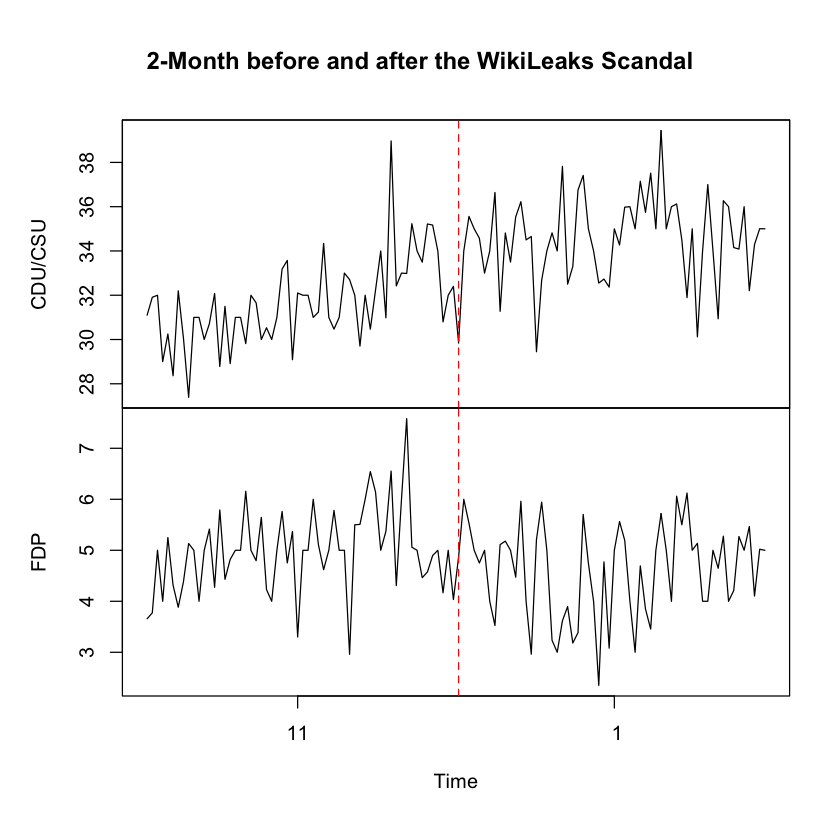

In [10]:
vlines <- c(v=time(ger21r)[61], v=time(ger21r)[61])
v.panel <- function(x, ...){
	lines(x, ...)
	panel.number <- parent.frame()$panel.number
	abline(v = vlines[panel.number], col = "red", lty=2)
}
plot(ger21r, panel=v.panel, main="2-Month before and after the WikiLeaks Scandal", xlab="Time")

Creating time indicator

In [11]:
nrow(ger21r)

[1] 120

In [12]:
ger21r$t <- seq(1,120,1)

Creating treatment variable

In [13]:
ger21r$scandal1 <- c(rep(0, 60), 1, rep(0, nrow(ger21r)-61))
ger21r$scandal2 <- c(rep(0, 60), rep(1, nrow(ger21r)-60))
ger21r$scandal3 <- c(rep(0, 120))

Testing the model specification for this data

In [14]:
summary(ur.df(ger21r$CDU, type="drift", selectlags="BIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6451 -1.2153  0.0226  1.4229  6.2307 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.74206    2.99882   3.916 0.000153 ***
z.lag.1     -0.35361    0.09046  -3.909 0.000157 ***
z.diff.lag  -0.32167    0.08836  -3.641 0.000409 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.035 on 115 degrees of freedom
Multiple R-squared:  0.3367,	Adjusted R-squared:  0.3252 
F-statistic: 29.19 on 2 and 115 DF,  p-value: 5.58e-11


Value of test-statistic is: -3.9089 7.6659 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.46 -2.88 -2.57
phi1  6.52  4.63  3.81


It shows that this time-series is **stationary** under 5% critical value

Testing for the **DGS** of this time-series

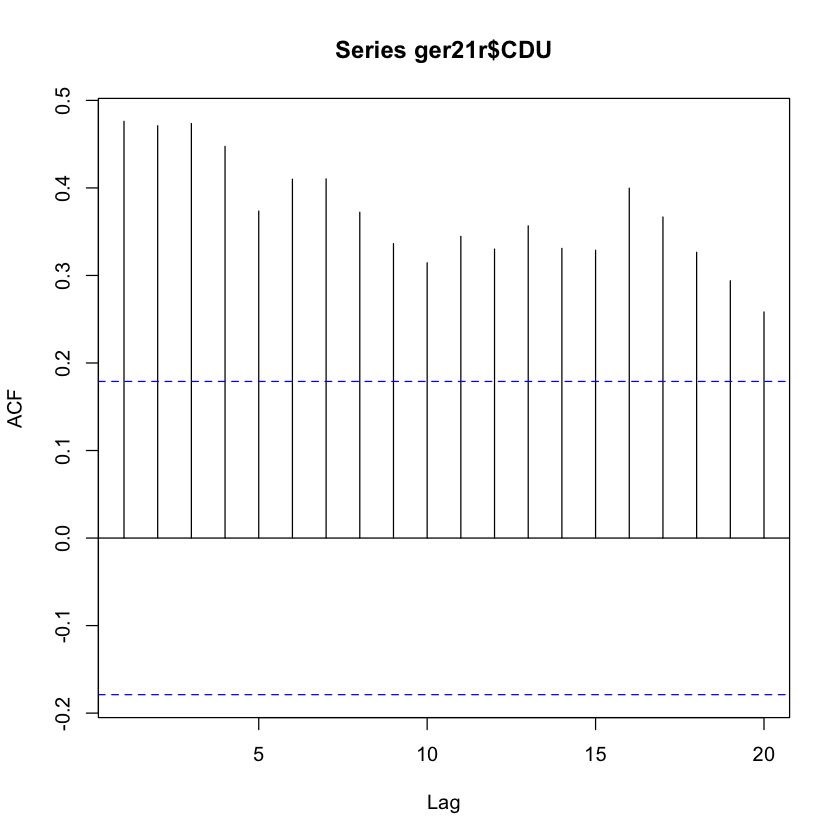

In [15]:
acf(ger21r$CDU)

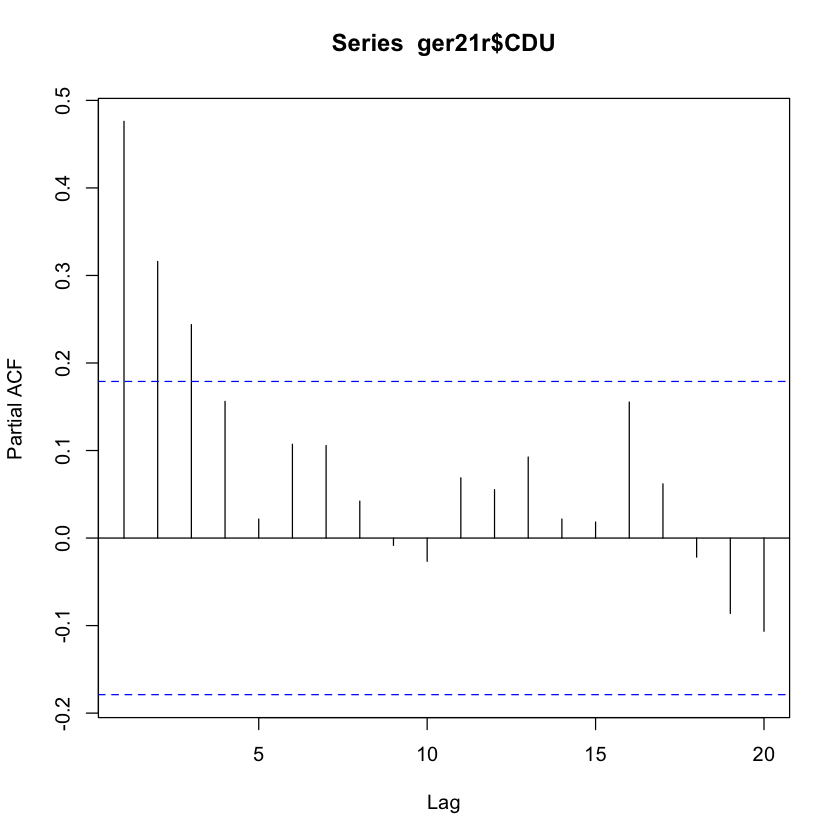

In [16]:
pacf(ger21r$CDU)

In [17]:
ger21r.cdu.ar1 <- arimax(ger21r$CDU, order=c(1,0,0))
ger21r.cdu.ar2 <- arimax(ger21r$CDU, order=c(2,0,0))
ger21r.cdu.ar3 <- arimax(ger21r$CDU, order=c(3,0,0))
ger21r.cdu.ar4 <- arimax(ger21r$CDU, order=c(4,0,0))
ger21r.cdu.ar5 <- arimax(ger21r$CDU, order=c(2,0,5))

BIC(ger21r.cdu.ar1, ger21r.cdu.ar2, ger21r.cdu.ar3, ger21r.cdu.ar4, ger21r.cdu.ar5)

,df,BIC
ger21r.cdu.ar1,3,534.3673
ger21r.cdu.ar2,4,526.3037
ger21r.cdu.ar3,5,523.5622
ger21r.cdu.ar4,6,525.1022
ger21r.cdu.ar5,9,533.6222


**BIC** shows **AR(3)** is the best for this data

Estimating the model

In [18]:
ger21r.cdu <- arimax(ger21r$CDU, order=c(3,0,0), xreg=cbind(ger21r$t, ger21r$scandal2, 	
					 ger21r$t*ger21r$scandal2)); ger21r.cdu


Call:
arimax(x = ger21r$CDU, order = c(3, 0, 0), xreg = cbind(ger21r$t, ger21r$scandal2, 
    ger21r$t * ger21r$scandal2))

Coefficients:
         ar1     ar2     ar3  intercept  ger21r$t  ger21r$scandal2
      0.0344  0.0280  0.0354    29.7718    0.0629           3.3593
s.e.  0.0911  0.0912  0.0919     0.5099    0.0145           1.4279
      ger21r$t * ger21r$scandal2
                         -0.0476
s.e.                      0.0206

sigma^2 estimated as 3.115:  log likelihood = -238.45,  aic = 490.9

Testing autocorrelation

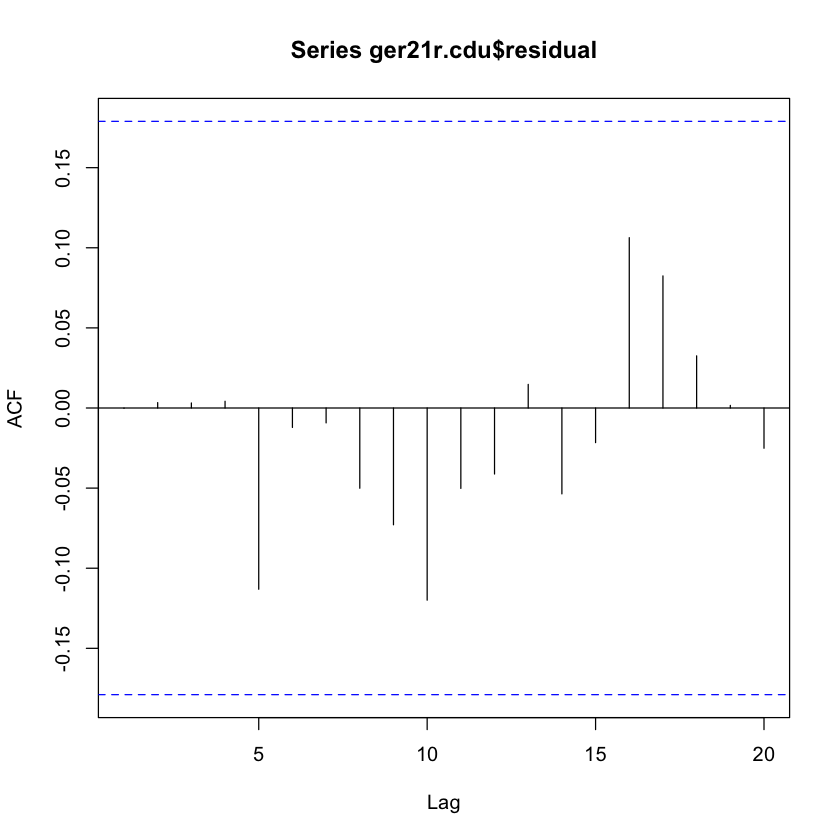

In [19]:
acf(ger21r.cdu$residual)

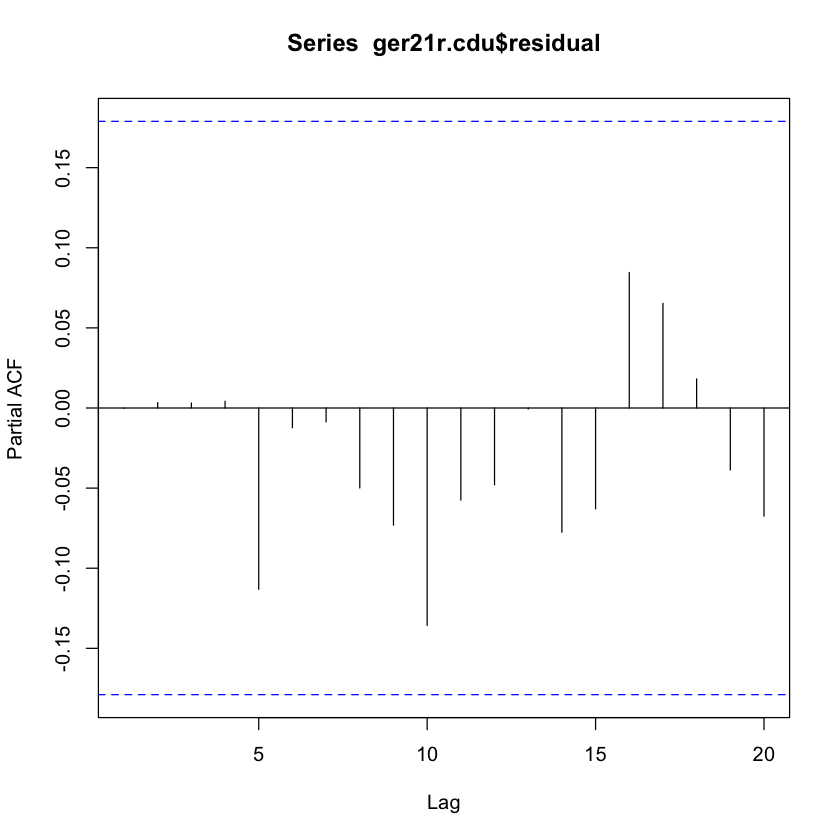

In [20]:
pacf(ger21r.cdu$residual)

In [21]:
Box.test(ger21r.cdu$residuals, lag=20, type="Ljung-Box")


	Box-Ljung test

data:  ger21r.cdu$residuals
X-squared = 8.4673, df = 20, p-value = 0.9883


The results show that there is **no autocorrelation**

In [22]:
ger21r.cdu.pred1 <- ger21r.cdu$coef[4] + ger21r.cdu$coef[5]*ger21r$t +
					ger21r.cdu$coef[6]*ger21r$scandal2 + ger21r.cdu$coef[7]*ger21r$t*ger21r$scandal2

ger21r.cdu.pred2 <- ger21r.cdu$coef[4] + ger21r.cdu$coef[5]*ger21r$t +
					ger21r.cdu$coef[6]*ger21r$scandal3 + ger21r.cdu$coef[7]*ger21r$t*ger21r$scandal3

ger21r.cdu.diff <- ger21r.cdu.pred1[61] - ger21r.cdu.pred2[61]

sprintf ("The difference is %s", ger21r.cdu.diff)

[1] "The difference is 0.456218842906289"

Parametric **Monte Carlo** Simulation for **95% CIs** (for plotting)

In [23]:
cdu1coef <- ger21r.cdu$coef
cdu1vcov <- vcov(ger21r.cdu)
cdu1draw <- mvrnorm(5000, cdu1coef, cdu1vcov)
ger21r$intercept <- rep(1, 120)
cdu1xs <- cbind(ger21r$intercept,ger21r$t,ger21r$scandal2,ger21r$t*ger21r$scandal2)
cdu1mcci <- cdu1xs%*%t(cdu1draw[,4:7])
cdu1lb <- apply(cdu1mcci, 1, function(x) quantile(x, probs=c(.025)))
cdu1ub <- apply(cdu1mcci, 1, function(x) quantile(x, probs=c(.975)))

Graph for **Local Effect**

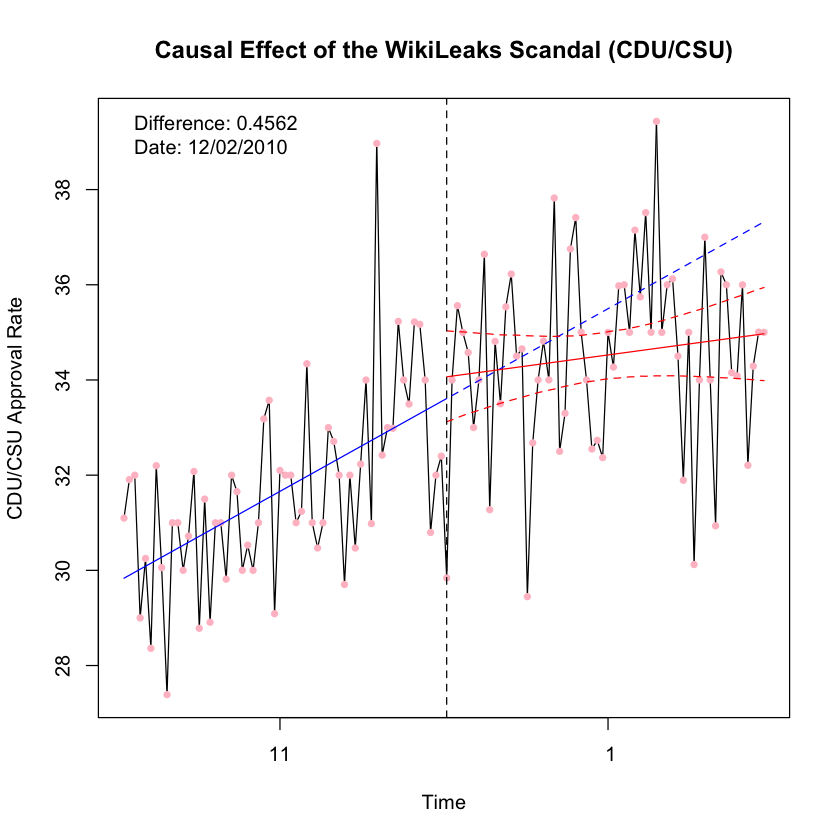

In [24]:
plot(y=ger21r$CDU, x=time(ger21r), type='l', ylab="CDU/CSU Approval Rate", xlab="Time",
	 main="Causal Effect of the WikiLeaks Scandal (CDU/CSU)")
points(time(ger21r), ger21r$CDU,
       col="pink",
       pch=20)
lines(y=ger21r.cdu.pred2[1:61], x=time(ger21r)[1:61], lty=1, col="blue")
lines(y=ger21r.cdu.pred2[62:120], x=time(ger21r)[62:120], lty=2, col="blue")
lines(y=ger21r.cdu.pred1[61:length(ger21r.cdu.pred1)], x=time(ger21r)[61:length(ger21r.cdu.pred1)], 
	  lty=1, col="red")
lines(y=cdu1lb[61:120], x=time(ger21r)[61:120], lty=2, col="red")
lines(y=cdu1ub[61:120], x=time(ger21r)[61:120], lty=2, col="red")
abline(v=time(ger21r)[61], lty=2)
Corner_text <- function(text, location="topleft"){
	legend(location, legend=text, bty="n", pch=NA)
}
Corner_text(text=c("Difference: 0.4562", "Date: 12/02/2010"))

Plotting the **Break Point(s)**

**Note:** The break points are detected through the **GAUSS** codes

In [25]:
ger21r$scandal1 <- c(rep(1,26), rep(0,(120-26)))
ger21r$scandal2 <- c(rep(0, 25), rep(1, (47-25)), rep(0,(120-47)))
ger21r$scandal3 <- c(rep(0, 46), rep(1,(120-46)))
ger21r.cdu1 <- mean(ger21r$CDU[1:26]); ger21r.cdu1
ger21r.cdu2 <- mean(ger21r$CDU[27:46]); ger21r.cdu2
ger21r.cdu3 <- mean(ger21r$CDU[47:120]); ger21r.cdu3

[1] 30.50948

[1] 31.85519

[1] 34.34918

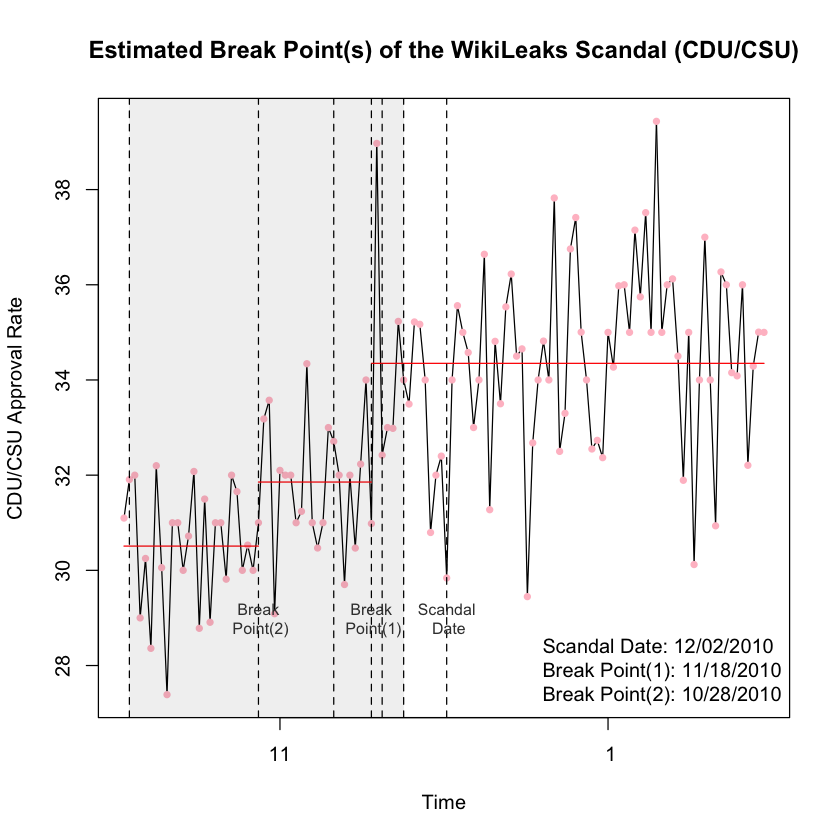

In [26]:
plot(y=ger21r$CDU, x=time(ger21r), type='l', ylab="CDU/CSU Approval Rate", xlab="Time",
	 main="Estimated Break Point(s) of the WikiLeaks Scandal (CDU/CSU)")
points(time(ger21r), ger21r$CDU,
       col="pink",
       pch=20)
lines(y=rep(ger21r.cdu1,26), x=time(ger21r)[1:26], lty=1, col="red")
lines(y=rep(ger21r.cdu2, (47-26+1)), x=time(ger21r)[26:47], lty=1, col="red")
lines(y=rep(ger21r.cdu3, (120-47+1)), x=time(ger21r)[47:120], lty=1, col="red")
abline(v=time(ger21r)[61], lty=2)
abline(v=time(ger21r)[2], lty=2)
abline(v=time(ger21r)[26], lty=2)
abline(v=time(ger21r)[47], lty=2)
abline(v=time(ger21r)[49], lty=2)
abline(v=time(ger21r)[40], lty=2)
abline(v=time(ger21r)[53], lty=2)
rect(time(ger21r)[2], 25, time(ger21r)[53], 40, border=NA, col="#00000011")
Corner_text <- function(text, location="bottomright"){
	legend(location, legend=text, bty="n", pch=NA)
}
Corner_text(text=c("Scandal Date: 12/02/2010","Break Point(1): 11/18/2010","Break Point(2): 10/28/2010"))
text(x = time(ger21r)[61], y = 29, paste("Scandal\n", "Date"), col="#3C3C3C", cex=0.8)
text(x = time(ger21r)[26], y = 29, paste("Break\n", "Point(2)"), col="#3C3C3C", cex=0.8)
text(x = time(ger21r)[47], y = 29, paste("Break\n", "Point(1)"), col="#3C3C3C", cex=0.8)